# Loading EEG data

In [2]:
import mne

** Loading EEG data works as follows. First, we need to know the file type of the file we want to load. In our case, the data is stored in an EDF file called S001R04.edf. Second, Python needs to know exactly where this file is located. We can either specify the full path to the file, or we can make sure that the file is in the current working directory, in which case the file name alone is sufficient. In this case, we can use the following command to load the raw data:**

In [3]:
# Loading the dataset
raw = mne.io.read_raw_edf("../Dataset/S001R04.edf", preload=True)

Extracting EDF parameters from C:\Users\Suyog_Asus\Working\Dataset\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


# Viewing and Editing meta information

In [4]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [5]:
raw.info["sfreq"]

160.0

# Renaming Channels

The output of raw.info revealed that some channel names are suffixed with one or more dots. Since these are non-standard names, let’s rename the channels by removing all trailing dots:

In [6]:
raw.rename_channels(lambda s: s.strip("."))

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

# Assigning a montage

For good measure (and for later use), we can assign a montage to the data (a montage relates channels names to standardized or actual locations on the scalp surface). First, let’s list all montages that ship with MNE.

In [7]:
mne.channels.get_builtin_montages()

['EGI_256',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'biosemi128',
 'biosemi16',
 'biosemi160',
 'biosemi256',
 'biosemi32',
 'biosemi64',
 'easycap-M1',
 'easycap-M10',
 'mgh60',
 'mgh70',
 'standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'artinis-octamon',
 'artinis-brite23']

According to the data set documentation (https://physionet.org/content/eegmmidb/1.0.0/), the channel locations conform to the international 10–10 system. MNE does not seem to ship a 10–10 montage, but standard_1020 contains template locations from the extended 10–20 system:


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


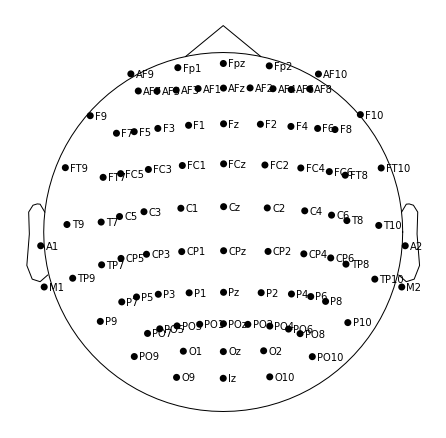

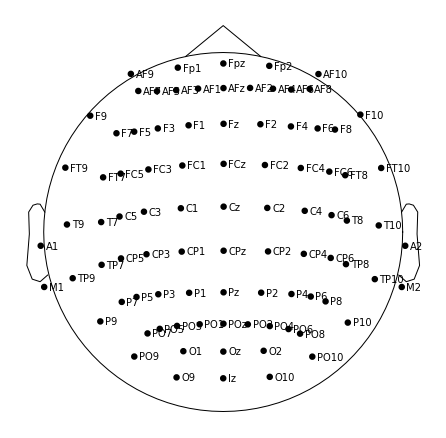

In [9]:
montage = mne.channels.make_standard_montage("standard_1020")
montage.plot()

It looks like this montage contains all channels used in our example data set. Therefore, we can assign this montage to our raw object.

In [8]:
raw.set_montage(montage, match_case=False)

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

# Re-referencing

The data documentation does not mention any reference electrode, but it is safe to assume that all channels are referenced to some standard location such as a mastoid or the nose. Often, we want to re-reference EEG data to the so-called average reference (the average over all recording channels). In MNE, we can compute average referenced signals as follows:

In [9]:

raw.set_eeg_reference("average")


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

# Annotations

Finally, many EEG data sets come with discrete events, either in the form of an analog stimulation channel or (text) annotations. Our example data set contains annotations that can be accessed with the annotations attribute:

In [10]:
raw.annotations

<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>

We see that there are 30 annotations in total. There are three kinds of annotations named T0, T1, and T2. According to the data set description, T0 corresponds to rest, T1 corresponds to motion onset of the left fist, and T2 corresponds to motion onset of the right fist.

If you encounter a file with an analog stimulation channel (this is typically the case for data recorded with BioSemi amplifiers), you need to extract discrete events from this channel as a first step. The mne.find_events function converts information contained in an analog stimulation channel to a NumPy array of shape (N, 3), where N (the number of rows) is the number of detected events. The first column contains event onsets (in samples), whereas the third column contains (integer) event codes. The second column contains the values of the stimulation channel one sample before the detected events (this column can usually be ignored).

This NumPy array can be converted to an Annotations object using mne.annotations_from_events, which is often necessary for further analyses (note that you can associate an existing Annotations object with a Raw object by calling the raw.set_annotations method).

# Visualization

We can now open an interactive visualization window as follows:

Using matplotlib as 2D backend.


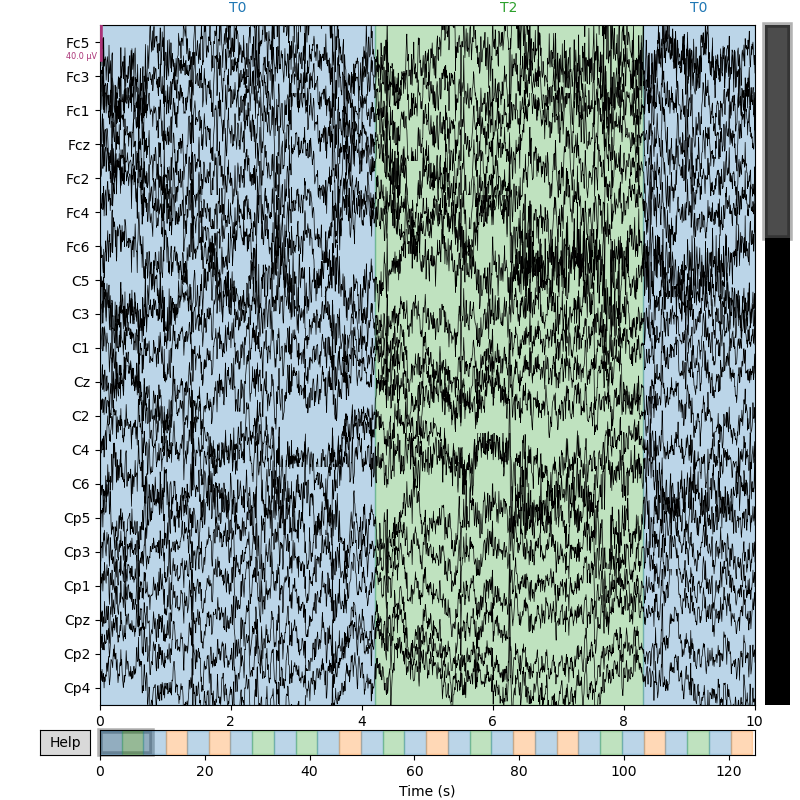

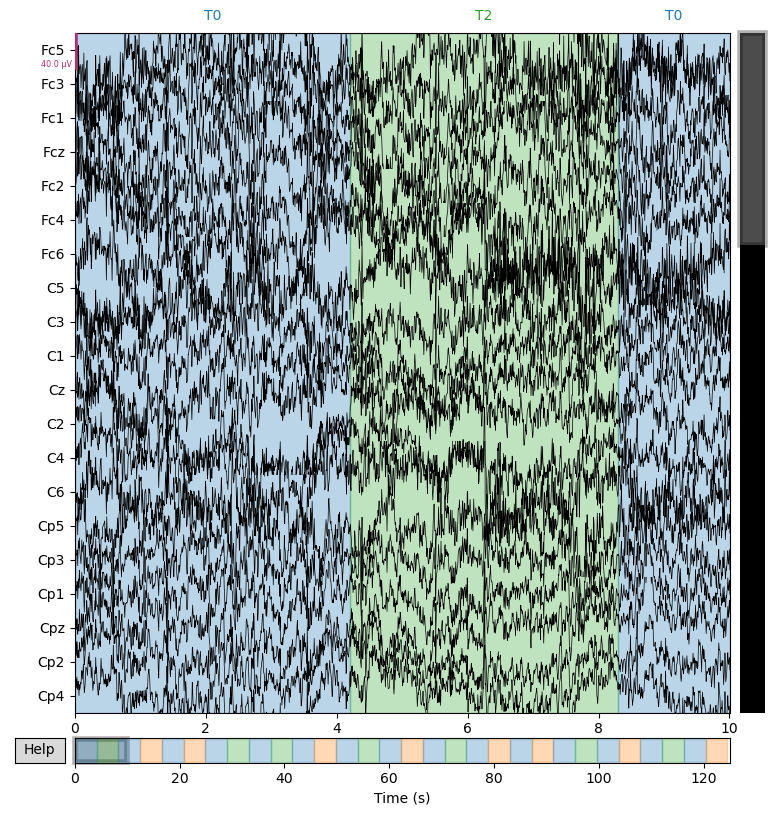

In [11]:
# for creating a responsive plot
%matplotlib widget
raw.plot()

You can change initial settings with arguments to raw.plot. For example, we might use the following arguments to start with suitable values for our example data:

Our data contains annotations (stored in raw.annotations), which are visualized as colored patches (the annotation descriptions are located at the top of the plot). In this case, the blue, red, and green patches correspond to T0, T1, and T2 annotations, respectively.

In addition to keyboard shortcuts, you can also use the mouse to navigate through the data. You might have already noticed the horizontal bar below the plot. This overview bar summarizes the whole time range of the signal, and the currently visible time segment is highlighted in (light) gray. You can click inside the overview bar to quickly skip around to different time segments. Furthermore, the overview bar also shows annotations.

To quickly identify time segments with high variance, you can switch to butterfly mode by pressing the b key. Signals of all channels of the same type will be collapsed onto each other, which makes it easy to spot abnormal activity. Press b again to exit butterfly mode.


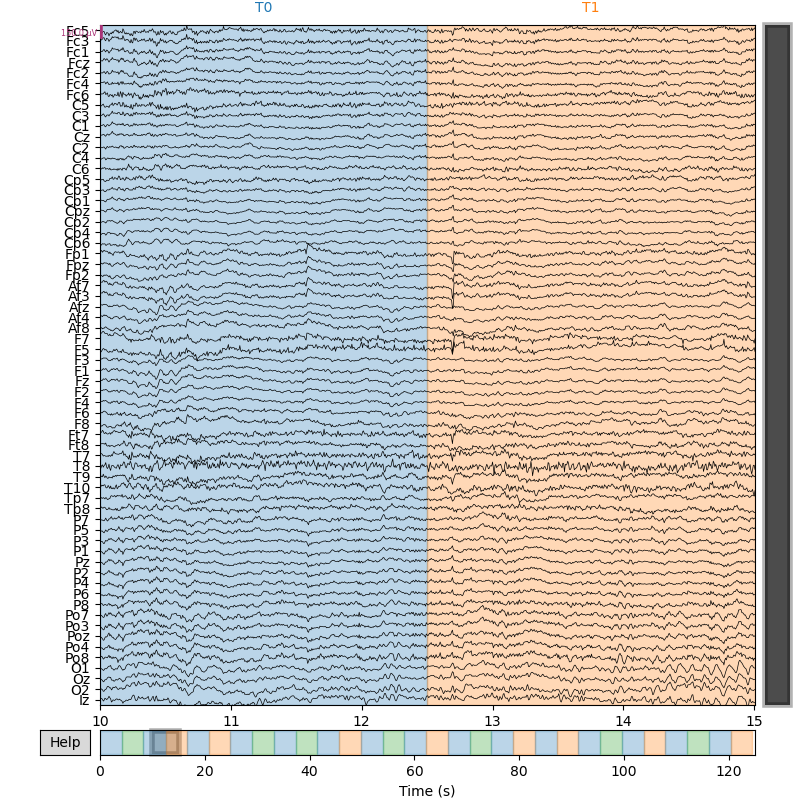

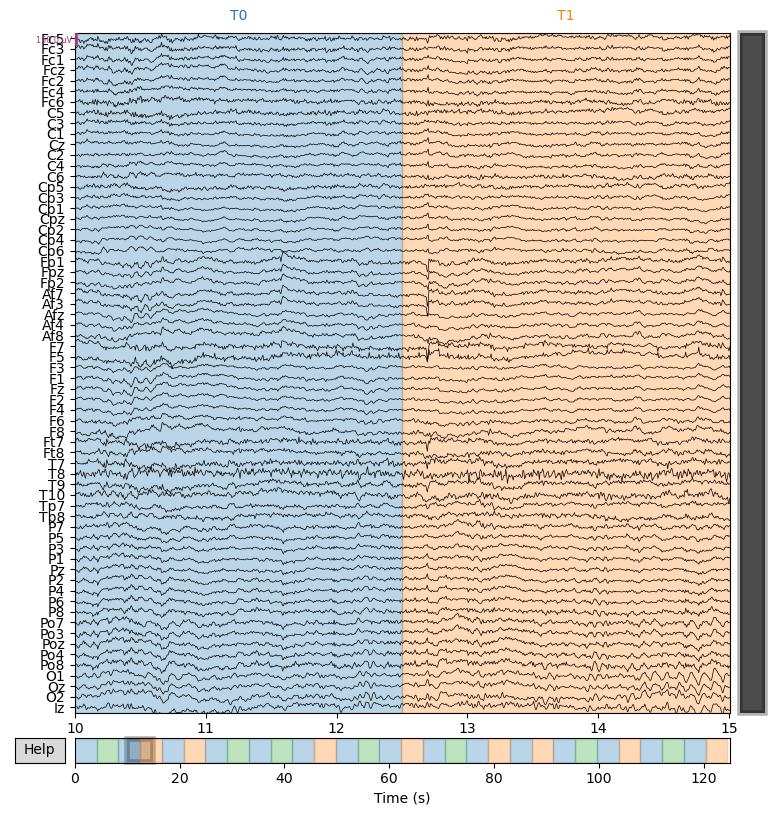

In [12]:
raw.plot(n_channels=64, duration=5, scalings={"eeg": 75e-6}, start=10)

If you want to focus on the actual signals with fewer distractions, you can get rid of the scroll and overview bars. Press z (zen mode) to toggle these user interface elements.

Finally, you can quickly filter out offsets (slow drifts) in the signals by pressing the d key (toggle DC removal).

In [13]:
raw.annotations

<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>

In [14]:
raw.annotations.save("S001R04_annotations.txt")


In [15]:
annotations = mne.read_annotations("S001R04_annotations.txt")


In [16]:
raw.set_annotations(annotations)


<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.9 MB, data loaded>

# Saving and loading bad channels

The following lines of code store the list of bad channels in a text file called S001R04_bads.txt:

In [18]:
with open("S001R04_bads.txt", "w") as f:
    f.write(",".join(raw.info["bads"]))
    f.write("\n")


To load this file and update the raw object, we can use:

In [19]:
with open("S001R04_bads.txt") as f:
    raw.info["bads"] = f.read().strip().split(",")


# END